In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import os
import sys
import time
import anno_func, json
import random
import copy
from collections import Counter
from math import fabs
from PIL import Image
import pandas as pd
from IPython.display import display

%matplotlib inline

In [2]:
datadir = "../data"

filedir = os.path.join(datadir,"valid_target.json")
annos = json.loads(open(filedir).read())

result_anno_file=os.path.join(datadir,"resnet101_predict.json")
results_annos=json.loads(open(result_anno_file).read())

In [3]:
print (len(results_annos['imgs']))
sm = anno_func.eval_annos(annos, results_annos, iou=0.5,types=anno_func.type5,minscore=50,check_type=True,minboxsize=0, maxboxsize=512)
print sm['report']

1000
iou:0.5, size:[0,512), types:[d, ...total 5...], accuracy:0.865326633166, recall:0.787740164684


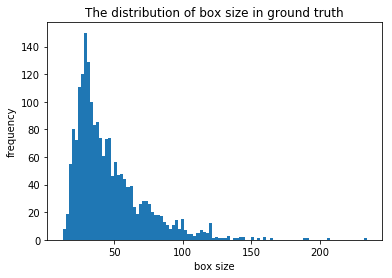

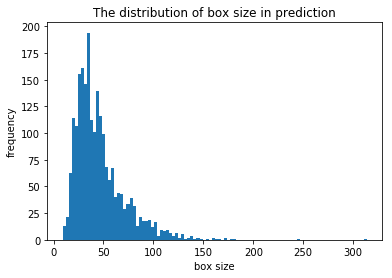

In [4]:
# ground truth
sizes = [ anno_func.box_long_size(obj['bbox']) for k,img in results_annos['imgs'].items() for obj in img['objects']]
pl.figure()
pl.title("The distribution of box size in ground truth")
pl.xlabel("box size")
pl.ylabel("frequency")
_ = pl.hist(sizes, bins=100)
# prediction
sizes = [ anno_func.box_long_size(obj['bbox']) for k,img in annos['imgs'].items() for obj in img['objects']]
pl.figure()
pl.title("The distribution of box size in prediction")
pl.xlabel("box size")
pl.ylabel("frequency")
_ = pl.hist(sizes, bins=100)

In [5]:
reload(anno_func)
df=pd.DataFrame(index=['Precision','Recall'])
#test_annos = res_annos2
#minscore=0.5
test_annos = results_annos
minscore=50

sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type5,
                         minboxsize=0,maxboxsize=400,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type5,
                         minboxsize=0,maxboxsize=32,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type5,
                         minboxsize=32,maxboxsize=96,minscore=minscore)
print sm['report']
sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=anno_func.type5,
                         minboxsize=96,maxboxsize=400,minscore=minscore)
print sm['report']

for tp in anno_func.type5:
    sm = anno_func.eval_annos(annos, test_annos, iou=0.5, check_type=True, types=[tp],minscore=minscore)
    print(sm['report'])
    

iou:0.5, size:[0,400), types:[d, ...total 5...], accuracy:0.865326633166, recall:0.787740164684
iou:0.5, size:[0,32), types:[d, ...total 5...], accuracy:0.759689922481, recall:0.689170182841
iou:0.5, size:[32,96), types:[d, ...total 5...], accuracy:0.918744971842, recall:0.839088905217
iou:0.5, size:[96,400), types:[d, ...total 5...], accuracy:0.882352941176, recall:0.789473684211
iou:0.5, size:[0,512), types:z, accuracy:0.847457627119, recall:0.841219768665
iou:0.5, size:[0,512), types:j, accuracy:0.929012345679, recall:0.893175074184
iou:0.5, size:[0,512), types:s, accuracy:0.906329113924, recall:0.8463356974
iou:0.5, size:[0,512), types:l, accuracy:0.870967741935, recall:0.870967741935
iou:0.5, size:[0,512), types:d, accuracy:0.788679245283, recall:0.506053268765


99 99.9891757965 iou:0.5, size:[0,400), types:[d, ...total 5...], accuracy:1.0, recall:0.000457456541629


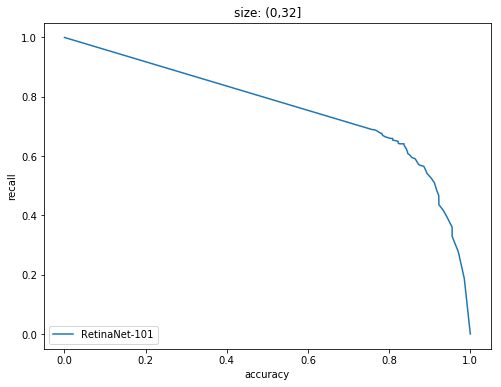

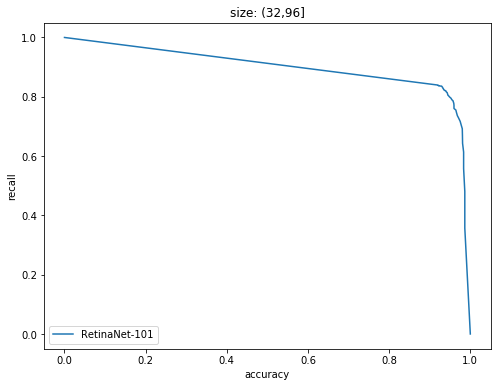

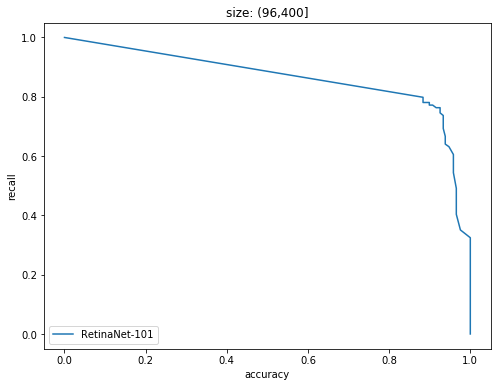

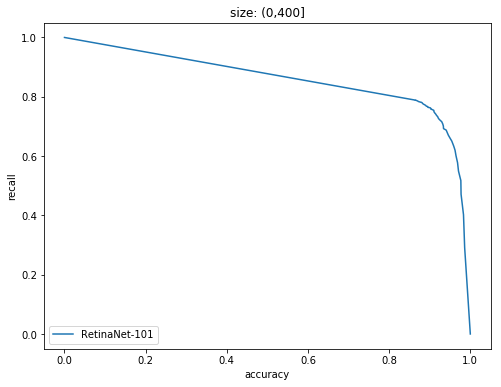

In [6]:
reload(anno_func)
def get_acc_res(results_annos, annos,**argv):
    scs = [ obj['score'] for k,img in results_annos['imgs'].items() for obj in img['objects']]
    scs = sorted(scs)
    accs = [0]
    recs = [1]
    for i, score in enumerate(np.linspace(0, scs[-1], 100)):
        sm = anno_func.eval_annos(annos, results_annos, iou=0.5, check_type=True, types=anno_func.type5, minscore=score, **argv)
        print "\r%s %s %s" % (i, score, sm['report']), 
        sys.stdout.flush()
        accs.append(sm['accuracy'])
        if len(accs)>=2 and accs[-1]<accs[-2]:
            accs[-1] = accs[-2]
        recs.append(sm['recall'])
    accs.append(1)
    recs.append(0)
    return accs, recs
sizes = [0,32,96,400]
ac_rc = []

for i in range(4):
    if i==3:
        l=sizes[0]
        r=sizes[-1]
    else:
        l=sizes[i]
        r=sizes[i+1]
    acc0, recs0 = get_acc_res(results_annos, annos, minboxsize=l, maxboxsize=r)
    ac_rc.append([acc0, recs0])
    
    pl.figure(figsize=(8,6))
    pl.plot(acc0, recs0, label='RetinaNet-101')
    pl.xlabel("accuracy")
    pl.ylabel("recall")
    pl.title("size: (%s,%s]"%(l,r))

    pl.legend(bbox_to_anchor=(0, 0), loc="lower left")

In [7]:
def compute_AP(acc, res):
    AP=0
    for i in range(1,len(acc)):
        AP+=fabs(res[i]-res[i-1])*0.5*(acc[i-1]+acc[i])
    return AP

In [8]:
MAP0=compute_AP(acc0, recs0)
print('RetinaNet-101', 'MAP: ',MAP0)

('RetinaNet-101', 'MAP: ', 0.8586124015556745)


In [20]:
# df=pd.read_excel('../data/AP.xlsx')
# display(df)